In [1]:
# SOME DEPENDENCIES COME FROM https://github.com/EmilienDupont/neural-processes
# IF not using this repo, use bits of code to initialize another NP / another learner

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
from matplotlib.pyplot import cm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
import torch.nn as nn
from data import generate_data, linear_quadratic

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def running_mean(x, N=100):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

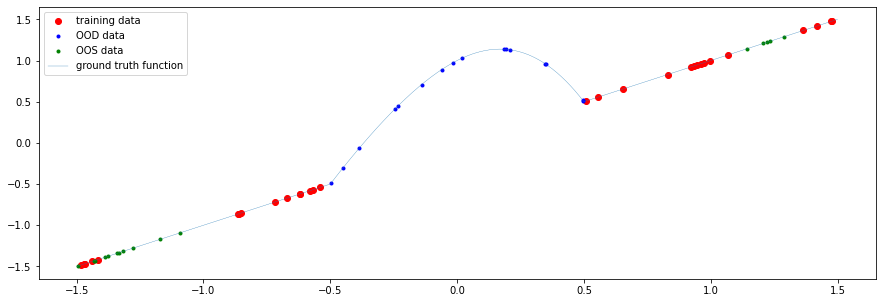

In [4]:
(x_train, y_train, oos_x, oos_y, ood_x, ood_y, oos_x_test,
 oos_y_test, ood_x_test, ood_y_test, x_test, y_test) = generate_data(32, 32, 32, seed=7, plot=True, device=device, shuffle=True, one_sine=False, oracle=linear_quadratic)

full_X = torch.cat((x_train, ood_x, oos_x))
full_Y= torch.cat((y_train, ood_y, oos_y))
full_data = TensorDataset(full_X, full_Y)

test_data = TensorDataset(torch.cat((ood_x_test, oos_x_test)), torch.cat((ood_y_test, oos_y_test)))
oos_ood = torch.cat((ood_x, oos_x)), torch.cat((ood_y, oos_y))

epoch 0
epoch 100
epoch 200
epoch 300
epoch 400


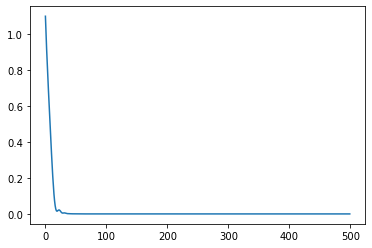

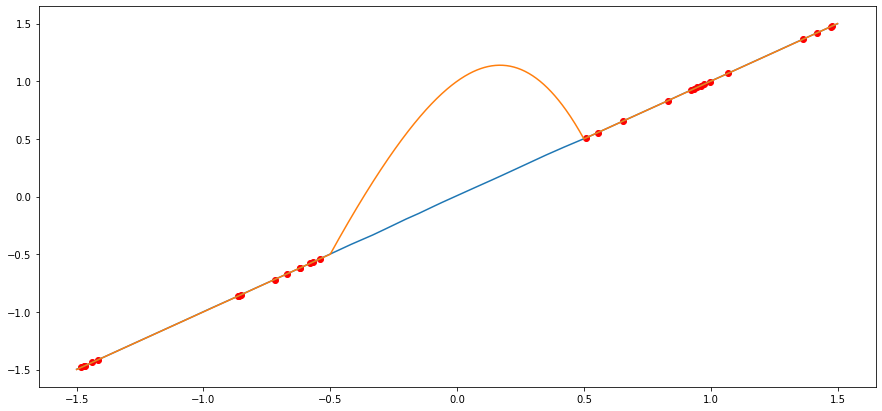

In [6]:
class main_net(nn.Module):
    def __init__(self, input_dim=1, width=128, n_hidden=2):
        super().__init__()
        self.x_layer = nn.Linear(input_dim, width)
        self.hiddens = nn.ModuleList([nn.Linear(width, width) for _ in range(n_hidden)])
        self.output_layer = nn.Linear(width, 1)
    
    def forward(self, x):
        out = F.relu(self.x_layer(x))
        for i, l in enumerate(self.hiddens):
            out = F.relu(l(out))
        return self.output_layer(out)

LR = 3e-4
EPOCHS = 500
BS = 16
loss_fn = nn.MSELoss()

mu_net = main_net().to(device=device)
optimizer = torch.optim.Adam(mu_net.parameters(), lr=LR)
loader = DataLoader(TensorDataset(x_train, y_train), batch_size=BS)

losses = []
for epoch in range(EPOCHS):
    if epoch % 100 == 0:
        print('epoch {}'.format(epoch))
    epoch_losses = []
    for batch_id, (xi, yi) in enumerate(loader):
        optimizer.zero_grad()
        pred = mu_net(xi)
        loss = loss_fn(pred, yi)
        epoch_losses.append(loss.item() * xi.shape[0])
        loss.backward()
        optimizer.step()
    losses.append(np.sum(epoch_losses) / x_train.shape[0])

plt.figure()
plt.plot(losses)
plt.show()

plt.figure(figsize=(15, 7))
plt.plot(x_train.cpu(), y_train.cpu(), 'ro')
plt.plot(x_test.cpu(), mu_net(x_test).detach().cpu(), label='predictions')
plt.plot(x_test.cpu(), y_test.cpu(), label='true')
plt.show()

In [7]:
residuals = mu_net(full_X) - full_Y

In [17]:
lengthscale = 0.1 # THIS PARAMETER IS THE GOAT !
epsilon = 1e-5
cov = (residuals@residuals.T) * torch.exp(-torch.cdist(full_X, full_X).pow(2)/(2 * lengthscale ** 2)) + epsilon * torch.eye(full_X.shape[0]).to(device=device)

In [18]:
dis = MultivariateNormal(torch.zeros(full_X.shape[0]), cov)

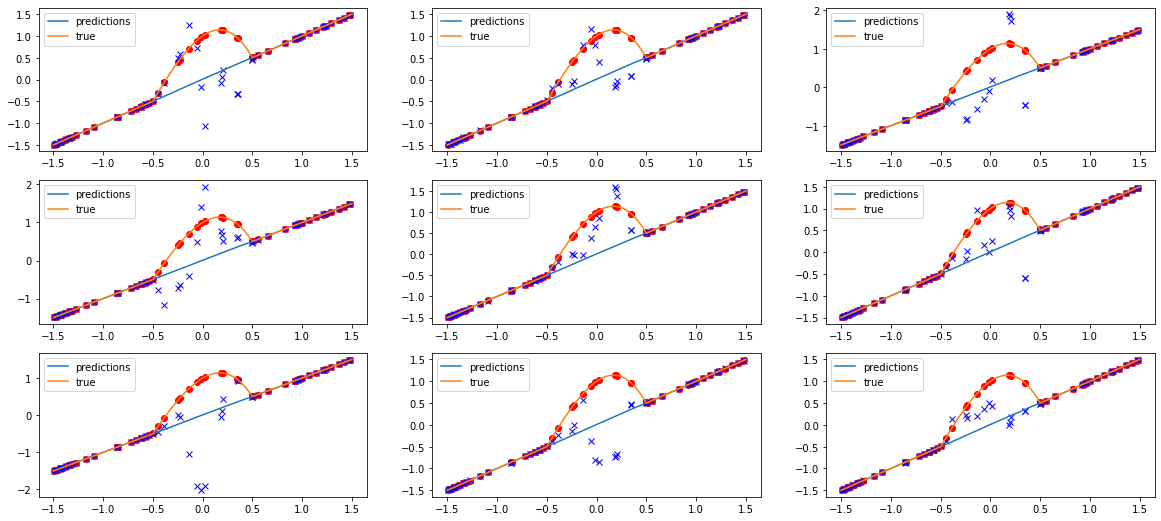

In [19]:
plt.figure(figsize=(20, 9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.plot(full_X.cpu(), full_Y.cpu(), 'ro')
    plt.plot(full_X.cpu(), mu_net(full_X).detach().cpu().squeeze() + dis.sample(), 'bx')
    plt.plot(x_test.cpu(), mu_net(x_test).detach().cpu(), label='predictions')
    plt.plot(x_test.cpu(), y_test.cpu(), label='true')
    plt.legend()
    
plt.show()

In [20]:
class MyData(Dataset):
    def __init__(self, num_samples=1000):
        self.num_samples = num_samples
        self.x_dim = 1  # x and y dim are fixed for this dataset.
        self.y_dim = 1

        # Generate data
        self.data = []
        for i in range(num_samples):
            x = full_X
            y = mu_net(full_X).detach() + dis.sample().unsqueeze(1)
            self.data.append((x, y))

    def __getitem__(self, index):
        return self.data[index]

    def __len__(self):
        return self.num_samples

In [21]:
# Create dataset
dataset = MyData(num_samples=2000)

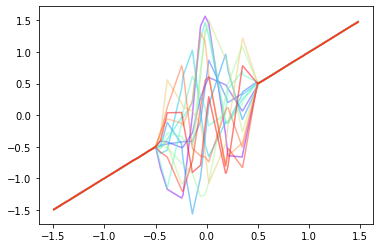

In [22]:
# Visualize data samples - Hopefully the trained NP should learn to generate similar trajectories
n = 15
color = iter(cm.rainbow(np.linspace(0, 1, n)))
for i in range(n):
    x, y = dataset[i] 
    x_sorted, indices = torch.sort(x, 0)
    y_sorted = y[indices.squeeze()]
    plt.plot(x_sorted.numpy(), y_sorted.numpy(), c=next(color), alpha=0.5)

### Build Neural Process

In [23]:
from neural_process import NeuralProcess

x_dim = 1
y_dim = 1
r_dim = 100  # Dimension of representation of context points
z_dim = 200  # Dimension of sampled latent variable
h_dim = 200  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Visualize samples from prior

We can visualize the prior (i.e. the output of the neural process without any context points) before training.

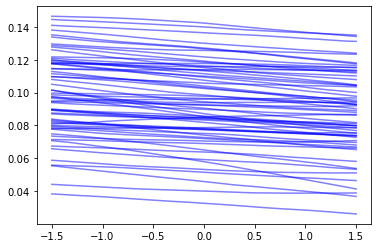

In [24]:
# Create a set of 100 target points, with shape 
# (batch_size, num_points, x_dim), which in this case is
# (1, 100, 1)
x_target = torch.Tensor(np.linspace(-1.5, 1.5, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))  # Shape (batch_size, z_dim)
    # Map x_target and z to p_y_target (which is parameterized by a 
    # normal with mean mu and std dev sigma)
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    # Plot predicted mean at each target point (note we could also
    # sample from distribution but plot mean for simplicity)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)


### Train Neural Process

In [ ]:
from torch.utils.data import DataLoader
from training import NeuralProcessTrainer

batch_size = 2
num_context = 16
num_target = 16

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 30)

iteration 200, loss 21.547
iteration 400, loss 15.655
iteration 600, loss 6.792
iteration 800, loss -10.538
iteration 1000, loss -10.786
Epoch: 0, Avg_loss: 6.945373624095733
iteration 1200, loss -22.984
iteration 1400, loss -22.490
iteration 1600, loss -25.097
iteration 1800, loss -27.903
iteration 2000, loss -26.798
Epoch: 1, Avg_loss: -23.514086871613777
iteration 2200, loss -18.664
iteration 2400, loss -28.981
iteration 2600, loss -31.991
iteration 2800, loss -23.327
iteration 3000, loss -20.984
Epoch: 2, Avg_loss: -26.067834666039854
iteration 3200, loss -35.992
iteration 3400, loss -21.316
iteration 3600, loss -30.062
iteration 3800, loss -31.352
iteration 4000, loss -26.992
Epoch: 3, Avg_loss: -26.87707296311442
iteration 4200, loss -33.683
iteration 4400, loss -24.062
iteration 4600, loss -32.729
iteration 4800, loss -31.861
iteration 5000, loss -26.768
Epoch: 4, Avg_loss: -26.375592664199768
iteration 5200, loss -23.675
iteration 5400, loss -27.919
iteration 5600, loss -25.482

### Visualize samples from trained prior

The prior should now encode some information about the shapes of the functions.

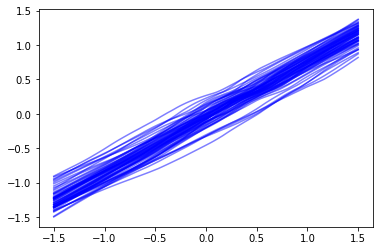

In [153]:
x_target = torch.Tensor(np.linspace(-1.5, 1.5, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

for i in range(64):
    z_sample = torch.randn((1, z_dim))
    mu, _ = neuralprocess.xz_to_y(x_target, z_sample)
    plt.plot(x_target.numpy()[0], mu.detach().numpy()[0], 
             c='b', alpha=0.5)


### Visualize samples from posterior

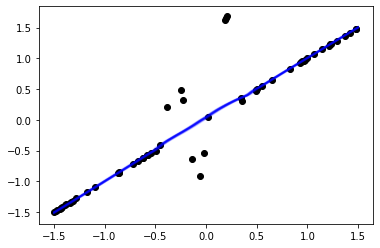

In [155]:
from utils import context_target_split

# Extract a batch from data_loader
for batch in data_loader:
    break

# Use batch to create random set of context points
x, y = batch
num_context = 61
num_target = 1
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

# Create a set of target points corresponding to entire [-pi, pi] range
x_target = torch.Tensor(np.linspace(-1.5, 1.5, 100))
x_target = x_target.unsqueeze(1).unsqueeze(0)

neuralprocess.training = False

for i in range(64):
    # Neural process returns distribution over y_target
    p_y_pred = neuralprocess(x_context, y_context, x_target)
    # Extract mean of distribution
    mu = p_y_pred.loc.detach()
    plt.plot(x_target.numpy()[0], mu.numpy()[0], 
             alpha=0.05, c='b')

plt.scatter(x_context[0].numpy(), y_context[0].numpy(), c='k')

In [114]:
x[0:1].shape

torch.Size([1, 62, 1])